### Sentiment Analysis

#### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

import re
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

from utils import *
from path import path



### sent analysis

import nltk
import statistics

#Preprocessing: tokenization and lemmatization

from nltk.tokenize import PunktSentenceTokenizer
sent_tokenizer = PunktSentenceTokenizer()

#Sentiment Analysis with VADER
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Sentiment Analysis with TextBlob
# !pip install textblob
from textblob import TextBlob

#Regression Metrics
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bruna\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Get the data

In [2]:
train_data = pd.read_csv(path + 'data_updated\\train.csv', index_col=-1)
test_data = pd.read_csv(path + 'data_updated\\test.csv', index_col=-1)

#### Get a data copy

In [3]:
train = train_data.copy()

#### Dataset with just the lyrics

In [4]:
lyrics = train['lyrics'].copy()
lyrics

id
535805     When you said you loved me\nDid you mean it th...
7519483    Kid Naruto Rap\n[Hook]\nEverybody wants you to...
4892808    [Verse 1]\nPeople tell me I've changed\nI find...
1584150    You've been warned about me\nDon't try to get ...
7639050    [Verse 1]\nI can see the end is coming but I’v...
                                 ...                        
1702980    If I knew when I was young that I'd be older\n...
4802970    [Intro: Lil Gotit]\nCash\nWah-wah-wah\nWah-wah...
403929     [Verse 1]\nI was born inside a home\nThe young...
1000723    Rollin' by the pool the falling stars are not ...
6177674    [Verse 1: GodlyRiskTaker A]\nYeah Epic Games, ...
Name: lyrics, Length: 134967, dtype: object

#### Stopwords Polarity

In [156]:
stopwords = nltk.corpus.stopwords.words('english')

In [188]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [152]:
vader = SentimentIntensityAnalyzer()

In [157]:
def vader_analysis(word_set, df):

    # filter lyrics
    df['filtered_lyrics'] = df['lyrics'].apply(lambda x: filter_lyrics(x, word_set))

    # polarity lyric by lyric
    df['polarity'] = df['filtered_lyrics'].apply(lambda x: vader.polarity_scores(x))

    # extract the compound
    df["polarity"] =  df["filtered_lyrics"].apply(lambda x: vader_wrapper(str(x)))

    # extract the label
    df['sentiment_label'] = np.select(
    [df['polarity'] < -0.2, df['polarity'] > 0.2],
    ['negative', 'positive'],
    default='neutral')
    
    df = df.drop("lyrics", axis=1)

    return df

In [158]:
stopwords_df = vader_analysis(stopwords, train)

In [161]:
stopwords_df

,title,tag,artist,year,views,features,stopwords,polarity,filtered_lyrics,sentiment_label
id,,,,,,,,,,
535805,Walk Away,rock,Tony Molina,2013,699,{},you you me you it then you your was it all it'...,0.0000,you you me you it then you your was it all it'...,neutral
7519483,Gotta Make It Kid Naruto Rap,rap,Reece Lett,2021,4,{Sl!ck},you to you to with your the in that it you to ...,0.0772,you to you to with your the in that it you to ...,neutral
4892808,​this is what i asked for,pop,Elliot (DNK),2019,389,{},me it to the same how to it again be now it al...,0.0000,me it to the same how to it again be now it al...,neutral
1584150,Stealing Hearts,pop,Katie Armiger,2013,126,{},been about me to too you to me down but you wi...,0.0000,been about me to too you to me down but you wi...,neutral
7639050,Get Ready,country,John Campbell Munro,1,2,{},can the is but the a to up the the where they ...,0.0000,can the is but the a to up the the where they ...,neutral
...,...,...,...,...,...,...,...,...,...,...
1702980,Manhattan,pop,Tijuana Sweetheart,2007,48,{},when was that be are so that you didn't have a...,0.0000,when was that be are so that you didn't have a...,neutral
4802970,Belly Shit,rap,Lil Gotit,2019,3593,"{""Lil Troup""}",is in the a that that these in the a a that a ...,-0.5267,is in the a that that these in the a a that a ...,negative
403929,The Four Loves,rock,Heath McNease,2014,301,{},was a of the who with that he it her to her th...,-0.2960,was a of the who with that he it her to her th...,negative


In [183]:
len(stopwords)

179

In [187]:
len(most_common_words)

2000

In [189]:
count = 0
for word in most_common_words:
    if word in stopwords:
        count += 1
        print(word)

can
not
me


In [216]:
count = 0
for word in relevant_words:
    if word in stopwords:
        count += 1
        print(word)

can
not
me


In [186]:
count

3

In [200]:
sent_compound_list = []

for word in stopwords:
    sent_compound_list.append(vader.polarity_scores(word)["compound"])

polarity = np.array(sent_compound_list).mean()

In [223]:
vader.polarity_scores("not")["compound"]

0.0

In [202]:
sent_compound_list

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.296,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 

In [203]:
polarity

0.0015413407821229048

In [214]:
for i in range(len(sent_compound_list)):
    if sent_compound_list[i] > 0.2 or sent_compound_list[i] < -0.2:
        print(stopwords[i])

no
won


#### Text Preprocessing

In [5]:
#### to utils

def sub_remove_2(x):

    '''
    tirei a parte que tirava os emojis - [^0-9A-Za-z]
    adicionei retirar emails e html tags
    '''
    
    # Remove noise
    x = re.sub(r"(@[A-Za-z0-9]+)|(\w+:\/\/\S+)|^rt|http.+?", "", x, flags=re.MULTILINE)
    
    # Replace newline and tab characters with spaces
    x = re.sub(r'[\t\n]', ' ', x)

    # Remove html tags
    x = re.sub(re.compile('<.*?>'), '', x)

    # Remove email addresses
    x = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', x)

    # Remove isolated consonants:
    x = re.sub(r'\b([^aeiou])\b',' ',x)

    # Remove space before punctuation
    x = re.sub(r'(\s)(?!\w)','',x)
    
    return x

In [6]:
def sentiment_preprocesser(data, text_column, target=None):

    #### deixei os emojis
    #### deixei as stopwords

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # Emoticons
                           u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # Transport & map symbols
                           u"\U0001F700-\U0001F77F"  # Alchemical symbols                           
                           u"\U0001F780-\U0001F7FF"  # Geometric shapes
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           "]+", flags=re.UNICODE)


    text_data = data[text_column].copy()
    
    functions = [lambda x: x.lower(), 
                    expand_contractions, 
                    sub_remove_2, 
                    sub_spaces
                ]

    for function in functions:
        text_data = text_data.apply(function)

    if target is not None:
        # tokenization
        regexp = RegexpTokenizer(r'\w+|' + emoji_pattern.pattern) ### adidiona emojis como tokens
        text_data = text_data.apply(regexp.tokenize)
           
        words = [word for tokens in text_data for word in tokens]
        words_unique = list(set(words))
        words_tagged = pos_tag(words_unique)
        words_pos_map = {word: get_wordnet_pos(pos_tag) for word, pos_tag in words_tagged}

        stopwords = nltk.corpus.stopwords.words('english')

        additional_functions = [lemmatize_with_mapping,
                    lambda x: [item for item in x if item not in stopwords],
                    lambda x: ' '.join(x)
                       ]
        
        # lemmatization and stopwords
        for additional_function in additional_functions:
            text_data = text_data.apply(additional_function, args=(words_pos_map,) 
                                        if additional_function == lemmatize_with_mapping else ())

    if target is not None:
        text_data = pd.DataFrame(text_data, columns=[text_column])
        text_data[target] = data[target]
    
    return text_data

In [7]:
lyrics_preproc = sentiment_preprocesser(train, 'lyrics', 'tag')

In [13]:
lyrics_preproc

,lyrics,tag
id,,
535805,say love mean change mind one day pretend caus...,rock
7519483,kid naruto rap hook everybody want hurt everyb...,rap
4892808,verse people tell change find hard explain may...,pop
1584150,warn try get close know want chain leave ghost...,pop
7639050,verse see end come never like odds need way ev...,country
...,...,...
1702980,know young old many thing would tell chance te...,pop
4802970,intro lil gotit cash wah wah wah wah wah wah e...,rap
403929,verse bear inside home young three boy fought ...,rock


In [14]:
emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # Emoticons
                        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
                        u"\U0001F700-\U0001F77F"  # Alchemical symbols                           
                        u"\U0001F780-\U0001F7FF"  # Geometric shapes
                        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                        u"\U0001FA00-\U0001FA6F"  # Chess symbols
                        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                        "]+", flags=re.UNICODE)

In [15]:
## verificar que não há stopwords
# stopwords = nltk.corpus.stopwords.words('english')

# for sentence in lyrics_preproc['lyrics']:
#     for word in sentence.split():
#         if word in stopwords:
#             print(word)

In [7]:
lyrics = lyrics_preproc['lyrics']
lyrics

id
535805     say love mean change mind one day pretend caus...
7519483    kid naruto rap hook everybody want hurt everyb...
4892808    verse people tell change find hard explain may...
1584150    warn try get close know want chain leave ghost...
7639050    verse see end come never like odds need way ev...
                                 ...                        
1702980    know young old many thing would tell chance te...
4802970    intro lil gotit cash wah wah wah wah wah wah e...
403929     verse born inside home young three boy fought ...
1000723    rollin pool fall star condescend twin nothing ...
6177674    verse godlyrisktaker yeah epic game playin gam...
Name: lyrics, Length: 134967, dtype: object

### Log Ratio

In [8]:
# Create a dictionary to store data for each genre
genre_freqs = {}

# Create a list to store all tokens from all genres
all_tokens = []

# Iterate through unique genres
for genre in lyrics_preproc['tag'].unique():
    # Create a subset of the DataFrame for the current genre
    genre_df = lyrics_preproc.loc[lyrics_preproc['tag'] == genre].drop(columns=['tag'])
    
    # Join the 'lyrics_string_fdist' column and tokenize
    genre_lyrics = ' '.join(list(genre_df['lyrics']))
    genre_tokens = word_tokenize(genre_lyrics)
    
    # Append tokens to the list for overall frequency distribution
    all_tokens.extend(genre_tokens)

    # Calculate frequency distribution for the current genre
    genre_freq = FreqDist(genre_tokens)
    
    # Store the data in the dictionary
    genre_freqs[f'freq_{genre}'] = genre_freq

# Calculate overall frequency distribution
overall_freq = FreqDist(all_tokens)

# Add the overall frequency distribution to the dictionary
genre_freqs['freq_all'] = overall_freq

# Access the frequency distributions for each genre and the overall frequency using genre_data
# For example: genre_data['freq_pop'], genre_data['freq_rap'], genre_data['overall_freq'], etc.


In [9]:
genre_freqs

{'freq_rock': FreqDist({'get': 31562, 'know': 29849, 'go': 28038, 'chorus': 26668, 'like': 22282, 'verse': 21783, 'time': 20419, 'love': 20370, 'come': 20016, 'oh': 19485, ...}),
 'freq_rap': FreqDist({'get': 212970, 'like': 163409, 'know': 104921, 'yeah': 90108, 'go': 83541, 'fuck': 77323, 'bitch': 70287, 'make': 63582, 'shit': 62407, 'verse': 61862, ...}),
 'freq_pop': FreqDist({'get': 93734, 'know': 91664, 'love': 87619, 'go': 78265, 'oh': 74223, 'like': 70241, 'na': 62757, 'chorus': 55937, 'say': 53283, 'come': 51731, ...}),
 'freq_country': FreqDist({'get': 7607, 'love': 5400, 'know': 5303, 'go': 5086, 'chorus': 4809, 'verse': 4472, 'like': 4293, 'say': 3411, 'time': 3265, 'oh': 3147, ...}),
 'freq_rb': FreqDist({'get': 19821, 'know': 19573, 'love': 19151, 'yeah': 15482, 'like': 13066, 'oh': 12839, 'baby': 12393, 'na': 12262, 'go': 11466, 'chorus': 10861, ...}),
 'freq_misc': FreqDist({'say': 22826, 'one': 17844, 'go': 16939, 'know': 14982, 'like': 14674, 'would': 14267, 'come': 1

In [10]:
genre_percentages = (lyrics_preproc['tag'].value_counts() / len(lyrics_preproc))

# Convert the Series to a dictionary
genre_percentages_dict = genre_percentages.to_dict()

In [11]:
genre_percentages_dict

{'pop': 0.4130046603984678,
 'rap': 0.28587728852237954,
 'rock': 0.18769032430149593,
 'rb': 0.04595938266391044,
 'misc': 0.041787992620418324,
 'country': 0.025680351493327997}

In [12]:
top_words = log_ratio(genre_freqs, genre_percentages, total_words=2000)

# Print top words for each genre
for genre, words in top_words.items():
    print(f'Top words for {genre}: {words}')

Top words for freq_rock: [('gah', 1.7756896096637274), ('blacken', 1.4740860703857697), ('oblivion', 1.409925552471363), ('pam', 1.3849501150981816), ('delusion', 1.3371937114604313), ('reborn', 1.3360854325040343), ('awaits', 1.318976375306415), ('unholy', 1.3137256412685245), ('abyss', 1.278135084170502), ('legion', 1.2676215216218523), ('forge', 1.2507147449718645), ('juda', 1.2299655091476887), ('suffocate', 1.2157173027755461), ('void', 1.2156617826911411), ('torment', 1.2142894264985475), ('rot', 1.1925833361333693), ('decay', 1.1861591194376078), ('devour', 1.1832222488601476), ('rust', 1.1795773880095402), ('guitar', 1.1661098667498073), ('emptiness', 1.1641100426234485), ('claw', 1.1408593118361965), ('chaos', 1.1407090265560074), ('unleash', 1.1395215189945365), ('agony', 1.1384179691308414), ('demise', 1.133832142752841), ('graf', 1.1204974829898395), ('solo', 1.1164185882240207), ('consume', 1.10650343978596), ('wither', 1.0704962383746885), ('salvation', 1.068601355267445)

In [149]:
lyrics_preproc["lyrics"]

id
535805     say love mean change mind one day pretend caus...
7519483    kid naruto rap hook everybody want hurt everyb...
4892808    verse people tell change find hard explain may...
1584150    warn try get close know want chain leave ghost...
7639050    verse see end come never like odds need way ev...
                                 ...                        
1702980    know young old many thing would tell chance te...
4802970    intro lil gotit cash wah wah wah wah wah wah e...
403929     verse bear inside home young three boys fought...
1000723    rollin pool fall star condescend twin nothing ...
6177674    verse godlyrisktaker yeah epic game playin gam...
Name: lyrics, Length: 134967, dtype: object

In [226]:
relevant_words = [word for sublist in top_words.values() for word, _ in sublist]
most_common_words = [pair[0] for pair in overall_freq.most_common(2000)]

# common_words_not_chosen = [word for word in most_common_words if word not in relevant_words]
# words_to_use = relevant_words + common_words_not_chosen

In [1]:
count = 0
for word in most_common_words:
    if word in stopwords:
        count += 1
        print(word)

NameError: name 'most_common_words' is not defined

In [146]:
print(most_common_words)
print(relevant_words)

count = 0
for word in most_common_words:
    if word not in relevant_words:
        count += 1

['get', 'like', 'know', 'go', 'love', 'say', 'yeah', 'na', 'make', 'see', 'come', 'oh', 'chorus', 'time', 'verse', 'one', 'take', 'want', 'feel', 'never', 'let', 'back', 'think', 'can', 'not', 'fuck', 'tell', 'way', 'wan', 'need', 'u', 'give', 'life', 'baby', 'look', 'well', 'bitch', 'day', 'gon', 'man', 'could', 'shit', 'keep', 'right', 'leave', 'would', 'girl', 'thing', 'away', 'try', 'still', 'night', 'heart', 'cause', 'nigga', 'call', 'find', 'live', 'run', 'mind', 'good', 'eye', 'break', 'world', 'every', 'even', 'niggas', 'put', 'lose', 'always', 'really', 'ta', 'around', 'talk', 'got', 'head', 'stay', 'hand', 'money', 'fall', 'little', 'nothing', 'light', 'hold', 'play', 'ever', 'god', 'new', 'em', 'long', 'face', 'stop', 'show', 'dream', 'wait', 'ya', 'die', 'hook', 'home', 'people', 'turn', 'end', 'much', 'bad', 'high', 'everything', 'hit', 'real', 'something', 'start', 'walk', 'lie', 'ooh', 'change', 'friend', 'move', 'hard', 'work', 'place', 'big', 'use', 'watch', 'alone', '

In [147]:
count

1073

In [14]:
def filter_lyrics(lyrics, word_set):
    return ' '.join(word for word in lyrics.split() if word in word_set)

In [24]:
lyrics_preproc

,lyrics,tag
id,,
535805,say love mean change mind one day pretend caus...,rock
7519483,kid naruto rap hook everybody want hurt everyb...,rap
4892808,verse people tell change find hard explain may...,pop
1584150,warn try get close know want chain leave ghost...,pop
7639050,verse see end come never like odds need way ev...,country
...,...,...
1702980,know young old many thing would tell chance te...,pop
4802970,intro lil gotit cash wah wah wah wah wah wah e...,rap
403929,verse bear inside home young three boy fought ...,rock


### Algorithms

In [25]:
# VADER performs very well with emojis, slangs and acronyms in sentences
        
#####  apagar os not related com emoções e deixar os outrs???

## VADER

In [72]:
vader = SentimentIntensityAnalyzer()

In [73]:
#### relevant words
relevant_words_set = set(relevant_words)

#### common words
common_words_set = set(most_common_words)


#### relevant + common words
# relevant_common_words_set = set(words_to_use)

In [74]:
### extract compound score

def vader_wrapper(filtered_lyrics):

    if type(filtered_lyrics) == list:

        sent_compound_list = []

        for sentence in filtered_lyrics:
            # calculates the compound sentiment score for each sentence using VADER 
            sent_compound_list.append(vader.polarity_scores(sentence)["compound"])

        polarity = np.array(sent_compound_list).mean()
        
    else:
        polarity = vader.polarity_scores(filtered_lyrics)["compound"]

    return polarity

In [75]:
def vader_analysis(word_set, df):

    # filter lyrics
    df['filtered_lyrics'] = df['lyrics'].apply(lambda x: filter_lyrics(x, word_set))

    # polarity lyric by lyric
    df['polarity'] = df['filtered_lyrics'].apply(lambda x: vader.polarity_scores(x))

    # extract the compound
    df["polarity"] =  df["filtered_lyrics"].apply(lambda x: vader_wrapper(str(x)))

    # extract the label
    df['sentiment_label'] = np.select(
    [df['polarity'] < -0.2, df['polarity'] > 0.2],
    ['negative', 'positive'],
    default='neutral')
    
    df = df.drop("lyrics", axis=1)

    return df

In [76]:
def polarity_by_gender(df):

    ### mean polarity by gender
    polarity_by_tag = df.groupby('tag')['polarity'].mean().reset_index()

    ### label
    polarity_by_tag['sentiment_label'] = np.select(
        [polarity_by_tag['polarity'] < -0.2, 
        polarity_by_tag['polarity'] > 0.2],
        ['negative', 'positive'],
        default='neutral')

    return polarity_by_tag

### 1. With Emojis and Without Stopwords

In [77]:
#### dataset with emojis, and without stopwords
emojis_df = lyrics_preproc

#### 1.1 With Relevant words

In [78]:
emojis_relevant_df = vader_analysis(relevant_words_set, emojis_df)
emojis_relevant_df

,tag,year,filtered_lyrics,polarity,sentiment_label
id,,,,,
535805,rock,2013,say love mind one day pretend cause walk away ...,0.5859,positive
7519483,rap,2021,rap hook want hurt want cry put time fall make...,-0.9823,negative
4892808,pop,2019,verse tell find hard maybe feel know make well...,0.5423,positive
1584150,pop,2013,get close know want leave take certain fallin ...,-0.9246,negative
7639050,country,1,verse end come need way around soil take steel...,0.9644,positive
...,...,...,...,...,...
1702980,pop,2007,know old thing would tell chance tell sit crow...,0.9815,positive
4802970,rap,2019,intro lil cash wah wah wah wah wah wah everyth...,-0.9981,negative
403929,rock,2014,verse bear inside home boys fought daddy heart...,0.9834,positive


##### 1.1.1 BY GENDER

In [79]:
emojis_relevant_df_by_gender = polarity_by_gender(emojis_relevant_df)
emojis_relevant_df_by_gender

,tag,polarity,sentiment_label
0,country,0.483938,positive
1,misc,0.363572,positive
2,pop,0.332176,positive
3,rap,-0.244748,negative
4,rb,0.456004,positive
5,rock,0.067043,neutral


In [80]:
### rap - negative

#### 1.2. With Relevant + Common words

In [160]:
# emojis_relevant_common_df = vader_analysis(relevant_common_words_set, emojis_df)
# emojis_relevant_common_df

##### 1.2.1 BY GENDER

In [82]:
emojis_relevant_common_df_by_gender = polarity_by_gender(emojis_relevant_common_df)

In [83]:
### rap - neutral

#### 1.3. With Common words

In [84]:
emojis_common_df = vader_analysis(common_words_set, emojis_df)
emojis_common_df

,tag,year,filtered_lyrics,polarity,sentiment_label
id,,,,,
535805,rock,2013,say love mean change mind one day cause see wa...,0.7717,positive
7519483,rap,2021,hook want want cry face put time work fall mak...,-0.9279,negative
4892808,pop,2019,verse people tell change find hard maybe feel ...,0.4404,positive
1584150,pop,2013,try get close know want leave take away stay s...,0.4404,positive
7639050,country,1,verse see end come never like need way even ar...,0.8515,positive
...,...,...,...,...,...
1702980,pop,2007,know young old many thing would tell tell say ...,0.9783,positive
4802970,rap,2019,intro everything chorus bitch god god shit shi...,-0.9987,negative
403929,rock,2014,verse inside home young heart god know make ha...,0.9781,positive


##### 1.3.1 BY GENDER

In [85]:
emojis_common_df_by_gender = polarity_by_gender(emojis_common_df)
emojis_common_df_by_gender

,tag,polarity,sentiment_label
0,country,0.510474,positive
1,misc,0.405783,positive
2,pop,0.372568,positive
3,rap,-0.027740,neutral
4,rb,0.504782,positive
5,rock,0.187713,neutral


In [86]:
### rap - neutral

### 2. Without Emojis and With Stopwords

In [87]:
#### dataset without emojis, and with stopwords
stopwords_df = text_preprocessing(train, "lyrics", "tag")

#### 2.1 With Relevant words

In [88]:
stopwords_relevant_df = vader_analysis(relevant_words_set, stopwords_df)
stopwords_relevant_df

,tag,filtered_lyrics,polarity,sentiment_label
id,,,,
535805,rock,say love me mind one day pretend cause walk aw...,0.5859,positive
7519483,rap,rap hook want hurt want cry put time fall make...,-0.9858,negative
4892808,pop,verse tell me find hard maybe feel not make we...,-0.7463,negative
1584150,pop,me not get close know want me leave take im ce...,0.6679,positive
7639050,country,verse can end come need way around turn soil w...,0.9811,positive
...,...,...,...,...
1702980,pop,old thing would not chance tell im sit im say ...,0.9838,positive
4802970,rap,intro lil cash everything chrome chorus lil li...,-0.9980,negative
403929,rock,verse inside home boys fight daddy heart stran...,0.9829,positive


##### 2.1.1 BY GENDER

In [89]:
stopwords_relevant_df_by_gender = polarity_by_gender(stopwords_relevant_df)
stopwords_relevant_df_by_gender

,tag,polarity,sentiment_label
0,country,0.406706,positive
1,misc,0.326663,positive
2,pop,0.284687,positive
3,rap,-0.203610,negative
4,rb,0.372365,positive
5,rock,0.046164,neutral


In [90]:
### rap - negative

#### 2.2 With Relevant + Common words

In [91]:
# stopwords_relevant_common_df = vader_analysis(relevant_common_words_set, stopwords_df)
# stopwords_relevant_common_df

,tag,filtered_lyrics,polarity,sentiment_label
id,,,,
535805,rock,say love me mean change mind one day pretend c...,0.7430,positive
7519483,rap,rap hook want hurt want cry face put time work...,-0.9927,negative
4892808,pop,verse people tell me change find hard maybe fe...,-0.7463,negative
1584150,pop,me not try get close know want me leave take i...,0.0377,neutral
7639050,country,verse can see end come never like need way eve...,0.9788,positive
...,...,...,...,...
1702980,pop,young old many thing would not chance tell im ...,0.9877,positive
4802970,rap,intro lil cash everything chrome chorus lil li...,-0.9986,negative
403929,rock,verse inside home young boys fight daddy heart...,0.9846,positive


##### 2.2.1 BY GENDER

In [92]:
stopwords_relevant_common_df_by_gender = polarity_by_gender(stopwords_relevant_common_df)
stopwords_relevant_common_df_by_gender

,tag,polarity,sentiment_label
0,country,0.433980,positive
1,misc,0.368747,positive
2,pop,0.314675,positive
3,rap,-0.070180,neutral
4,rb,0.418076,positive
5,rock,0.072404,neutral


In [93]:
### rap - neutral

#### 2.3 With Common words

In [94]:
stopwords_common_df = vader_analysis(common_words_set, stopwords_df)
stopwords_common_df

,tag,filtered_lyrics,polarity,sentiment_label
id,,,,
535805,rock,say love mean change mind one day cause see wa...,0.7717,positive
7519483,rap,hook want want cry face put time work fall mak...,-0.8902,negative
4892808,pop,verse people tell change find hard maybe feel ...,-0.7871,negative
1584150,pop,not try get close know want leave take im im a...,-0.8372,negative
7639050,country,verse can see end come never like need way eve...,0.9501,positive
...,...,...,...,...
1702980,pop,young old many thing would not tell im im say ...,0.9840,positive
4802970,rap,intro everything chorus bitch im god god see k...,-0.9986,negative
403929,rock,verse inside home young fight heart god know m...,0.9738,positive


##### 2.3.1 BY GENDER

In [95]:
stopwords_common_df_by_gender = polarity_by_gender(stopwords_common_df)
stopwords_common_df_by_gender

,tag,polarity,sentiment_label
0,country,0.415798,positive
1,misc,0.317826,positive
2,pop,0.303168,positive
3,rap,-0.005496,neutral
4,rb,0.409664,positive
5,rock,0.141662,neutral


In [96]:
### rap - neutral

## Comparissons

In [97]:
def sentiment_differences_across_genres(dataframes, titles, ncols):

    # Set up subplots
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(18, 6))

    # Plot each DataFrame
    for i, (df, title) in enumerate(zip(dataframes, titles)):
        sns.barplot(x='tag', y='polarity', data=df, ax=axes[i])
        axes[i].set_title(f'Sentiment Differences ({title})')
        axes[i].set_xlabel('Genre')
        axes[i].set_ylabel('Mean Sentiment Score')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

#### With Emojis and Without Stopwords

relevant VS revelant + common VS common

In [98]:
# emojis_relevant_df_by_gender
# emojis_relevant_common_df_by_gender
# emojis_common_df_by_gender

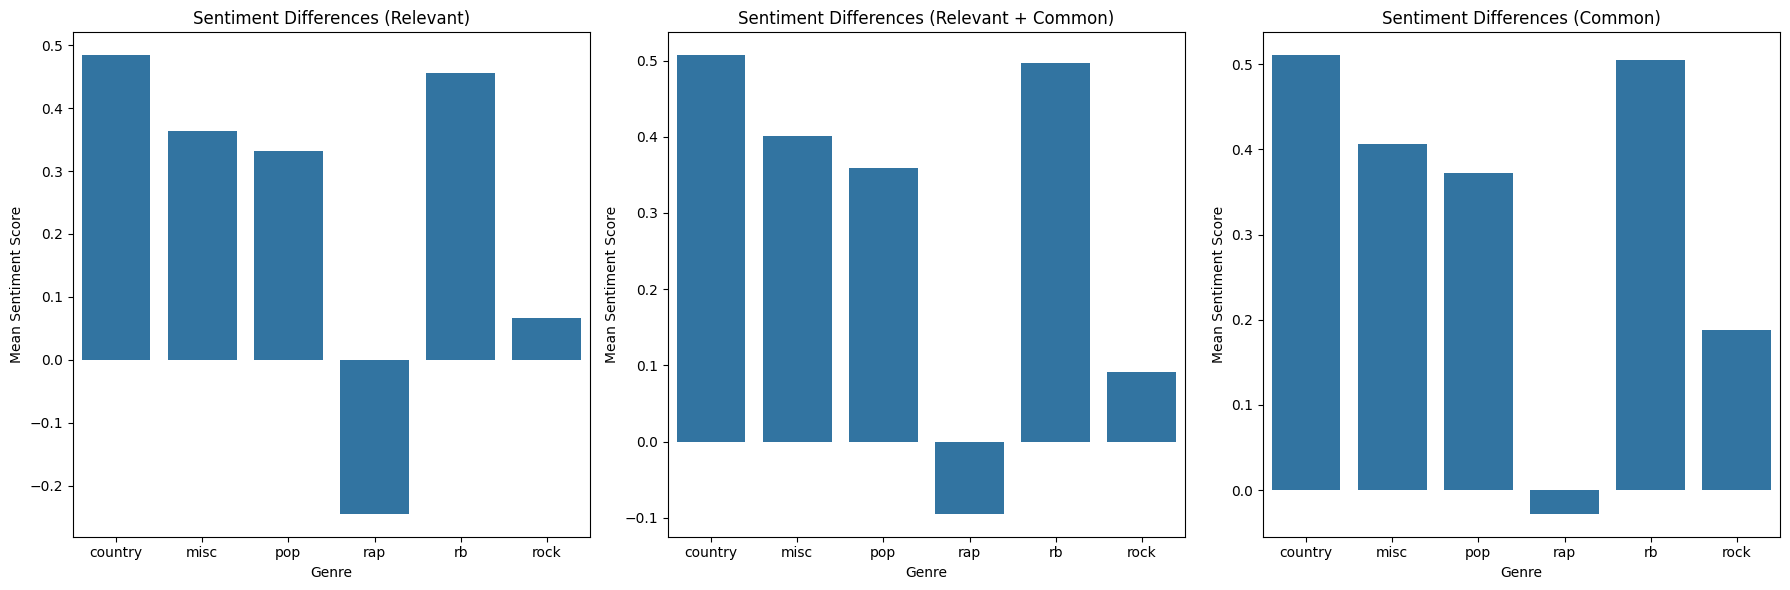

In [99]:
dataframes = [emojis_relevant_df_by_gender, emojis_relevant_common_df_by_gender, emojis_common_df_by_gender]
titles = ['Relevant', 'Relevant + Common', 'Common']

sentiment_differences_across_genres(dataframes, titles, ncols=3)

#### Without Emojis and With Stopwords

relevant VS revelant + common VS common

In [100]:
# stopwords_relevant_df_by_gender
# stopwords_relevant_common_df_by_gender
# stopwords_common_df_by_gender

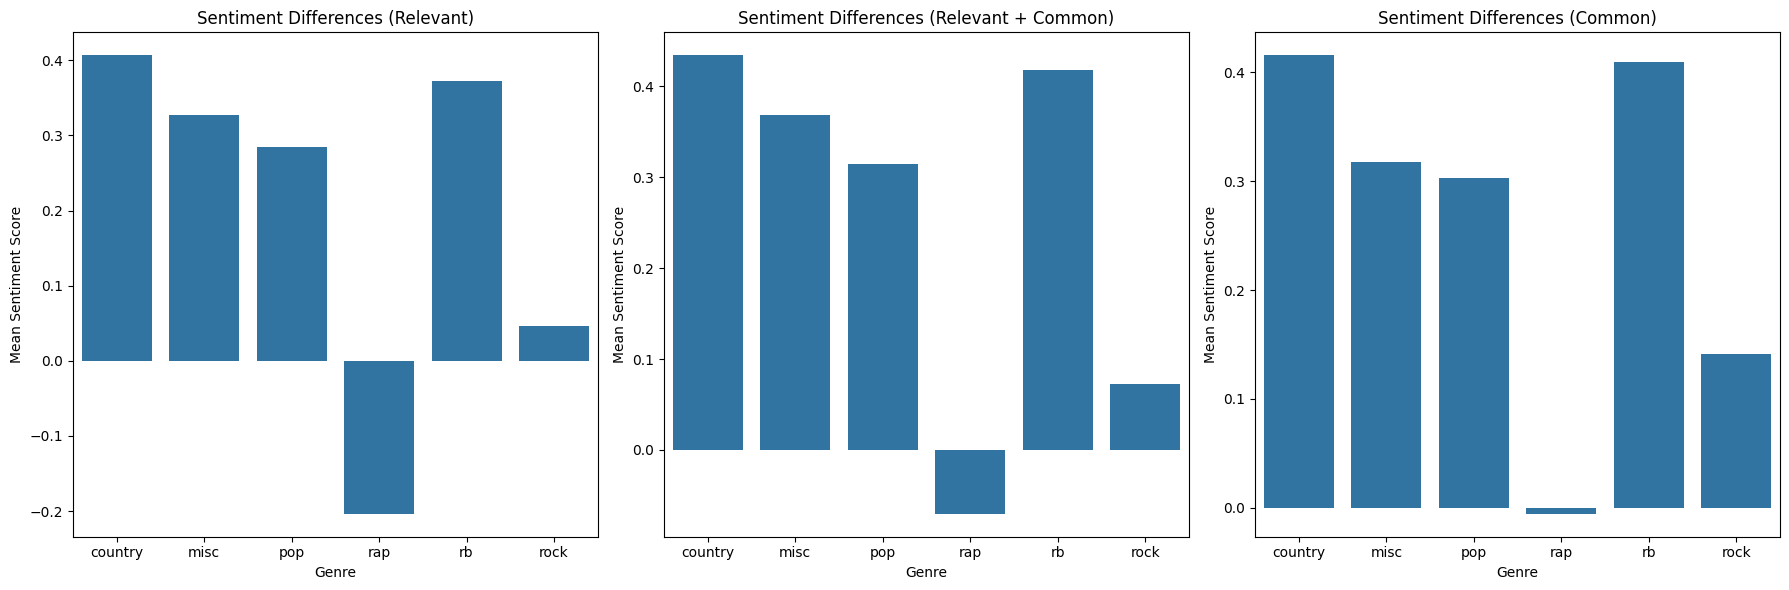

In [101]:
dataframes = [stopwords_relevant_df_by_gender, stopwords_relevant_common_df_by_gender, stopwords_common_df_by_gender]
titles = ['Relevant', 'Relevant + Common', 'Common']

sentiment_differences_across_genres(dataframes, titles, ncols=3)

#### Relevant

With Emojis and Without Stopwords VS Without Emojis and With Stopwords

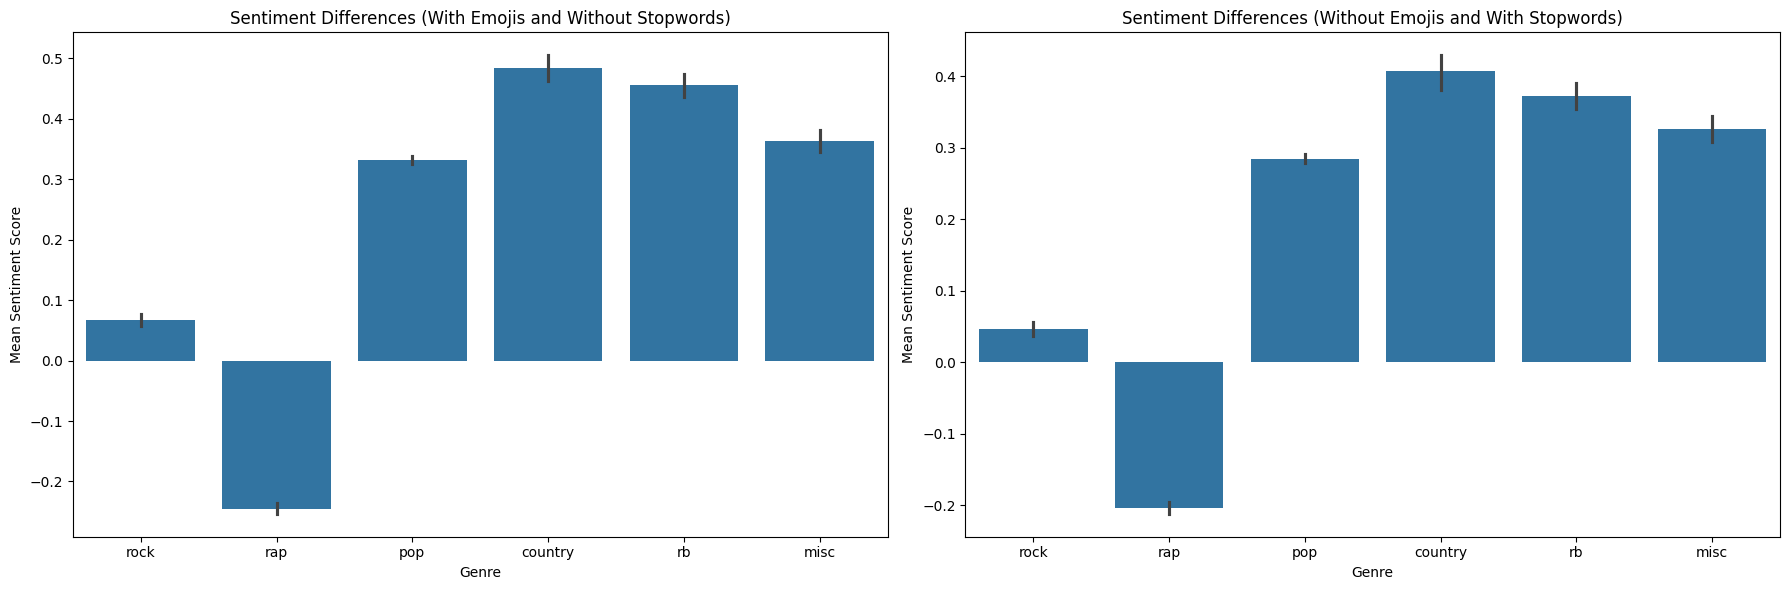

In [102]:
dataframes = [emojis_relevant_df, stopwords_relevant_df]
titles = ['With Emojis and Without Stopwords', 'Without Emojis and With Stopwords']

sentiment_differences_across_genres(dataframes, titles, ncols=2)

#### Revelant + Common

With Emojis and Without Stopwords VS Without Emojis and With Stopwords

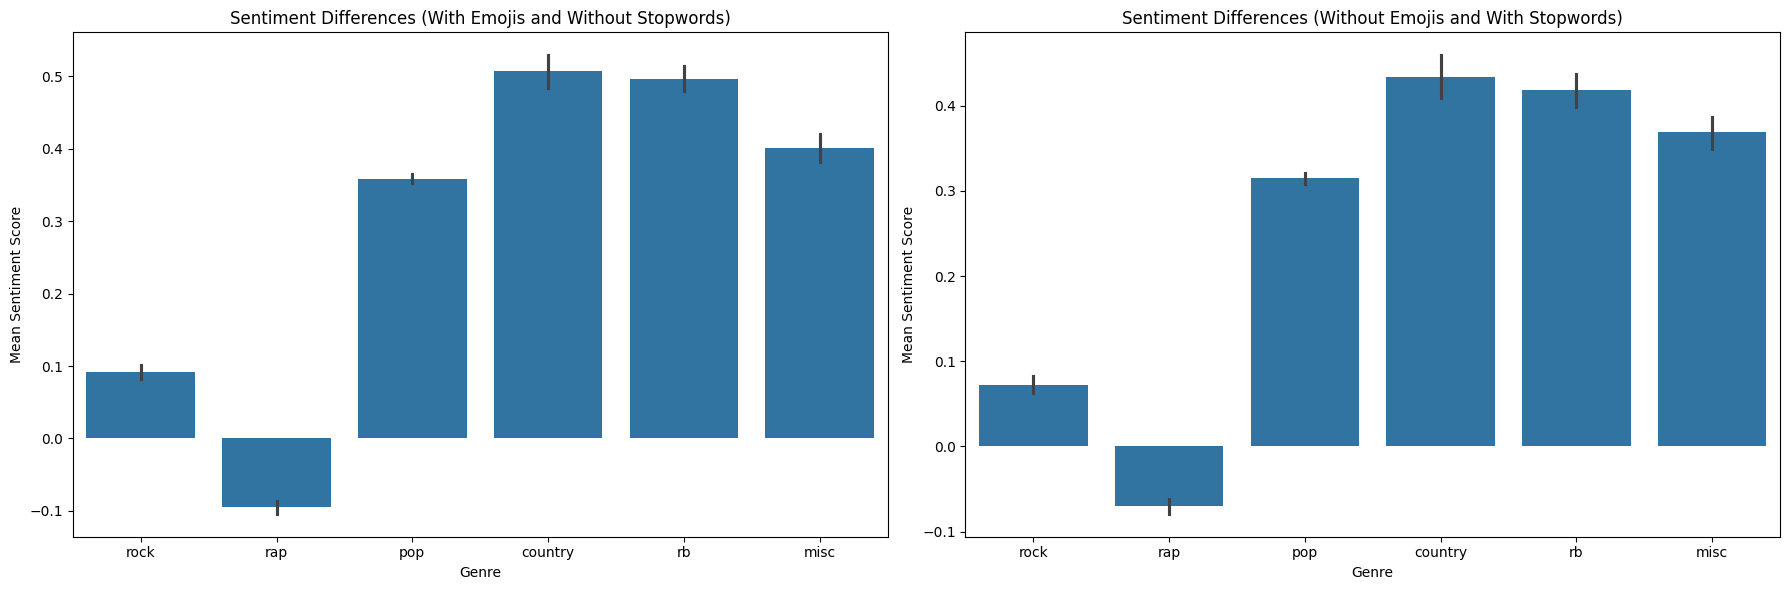

In [103]:
dataframes = [emojis_relevant_common_df, stopwords_relevant_common_df]
titles = ['With Emojis and Without Stopwords', 'Without Emojis and With Stopwords']

sentiment_differences_across_genres(dataframes, titles, ncols=2)

#### Common

With Emojis and Without Stopwords VS Without Emojis and With Stopwords

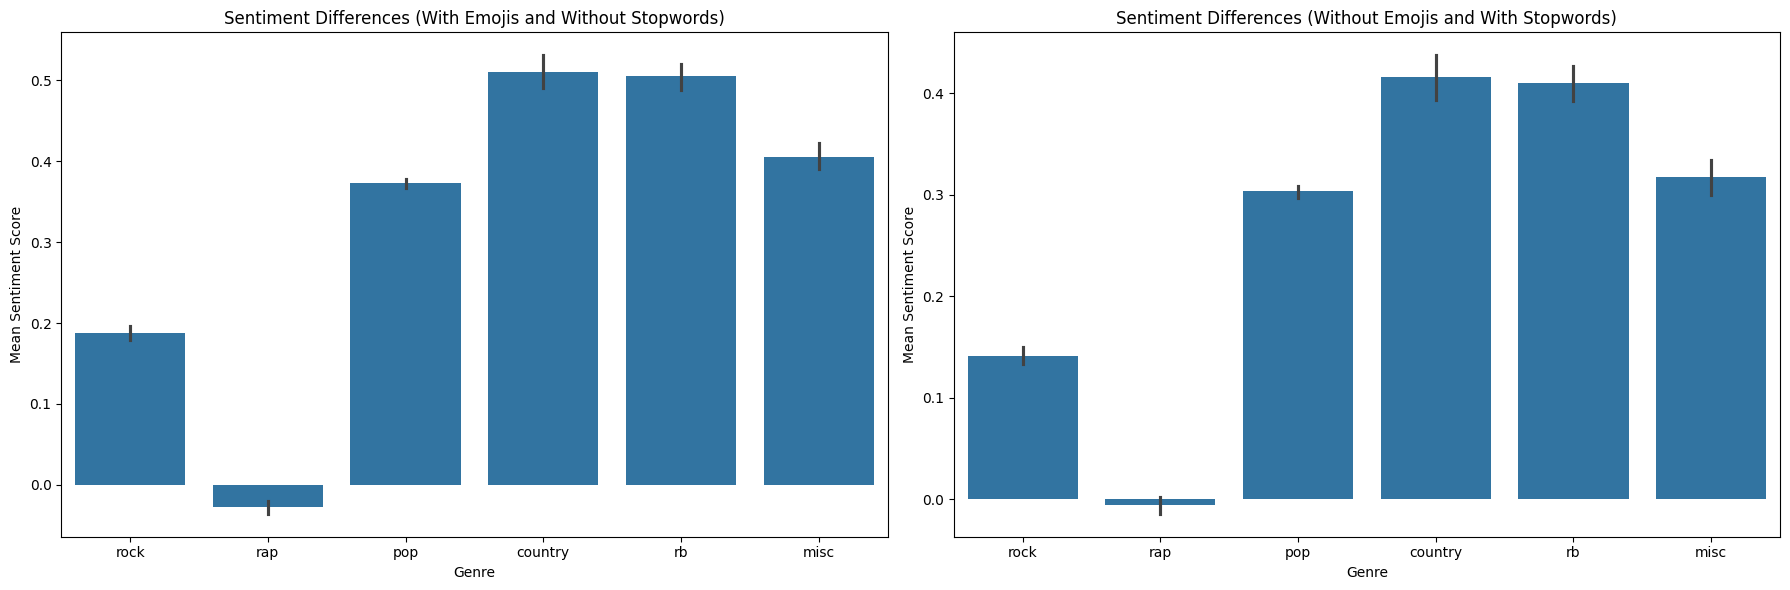

In [104]:
dataframes = [emojis_common_df, stopwords_common_df]
titles = ['With Emojis and Without Stopwords', 'Without Emojis and With Stopwords']

sentiment_differences_across_genres(dataframes, titles, ncols=2)

### TextBlob

In [105]:
def textblob_analysis(word_set, df):

    # filter lyrics
    df['filtered_lyrics'] = df['lyrics'].apply(lambda x: filter_lyrics(x, word_set))

    df['polarity'] = df['filtered_lyrics'].apply(lambda x: TextBlob(x).sentiment.polarity)    

    # for lyric in df['filtered_lyrics']:
    #     analysis = TextBlob(lyric)
    #     analysis.sentiment  	    

    # extract the label
    df['sentiment_label'] = np.select(
    [df['polarity'] < -0.2, df['polarity'] > 0.2],
    ['negative', 'positive'],
    default='neutral')
    
    df = df.drop("lyrics", axis=1)

    return df

    # return analysis.sentiment.polarity

### 1. With Emojis and Without Stopwords

In [106]:
emojis_df2 = lyrics_preproc.copy()
emojis_df2

,lyrics,tag,year,filtered_lyrics,polarity,sentiment_label
id,,,,,,
535805,say love mean change mind one day pretend caus...,rock,2013,say love mean change mind one day cause see wa...,0.7717,positive
7519483,kid naruto rap hook everybody want hurt everyb...,rap,2021,hook want want cry face put time work fall mak...,-0.9279,negative
4892808,verse people tell change find hard explain may...,pop,2019,verse people tell change find hard maybe feel ...,0.4404,positive
1584150,warn try get close know want chain leave ghost...,pop,2013,try get close know want leave take away stay s...,0.4404,positive
7639050,verse see end come never like odds need way ev...,country,1,verse see end come never like need way even ar...,0.8515,positive
...,...,...,...,...,...,...
1702980,know young old many thing would tell chance te...,pop,2007,know young old many thing would tell tell say ...,0.9783,positive
4802970,intro lil gotit cash wah wah wah wah wah wah e...,rap,2019,intro everything chorus bitch god god shit shi...,-0.9987,negative
403929,verse bear inside home young three boys fought...,rock,2014,verse inside home young heart god know make ha...,0.9781,positive


#### 1.1 With Relevant words

In [107]:
emojis_relevant_df2 = textblob_analysis(relevant_words_set, emojis_df2)
emojis_relevant_df2 

,tag,year,filtered_lyrics,polarity,sentiment_label
id,,,,,
535805,rock,2013,say love mind one day pretend cause walk away ...,0.500000,positive
7519483,rap,2021,rap hook want hurt want cry put time fall make...,0.180952,neutral
4892808,pop,2019,verse tell find hard maybe feel know make well...,0.237925,positive
1584150,pop,2013,get close know want leave take certain fallin ...,-0.091005,neutral
7639050,country,1,verse end come need way around soil take steel...,0.625000,positive
...,...,...,...,...,...
1702980,pop,2007,know old thing would tell chance tell sit crow...,0.328571,positive
4802970,rap,2019,intro lil cash wah wah wah wah wah wah everyth...,0.063240,neutral
403929,rock,2014,verse bear inside home boys fought daddy heart...,0.192949,neutral


##### 1.1.1 BY GENDER

In [108]:
emojis_relevant_df2_by_gender = polarity_by_gender(emojis_relevant_df2)
emojis_relevant_df2_by_gender

,tag,polarity,sentiment_label
0,country,0.156557,neutral
1,misc,0.128221,neutral
2,pop,0.133421,neutral
3,rap,0.014739,neutral
4,rb,0.152271,neutral
5,rock,0.075543,neutral


#### 1.2. With Relevant + Common words

In [109]:
emojis_relevant_common_df2 = textblob_analysis(relevant_common_words_set, emojis_df2)
emojis_relevant_common_df2 

,tag,year,filtered_lyrics,polarity,sentiment_label
id,,,,,
535805,rock,2013,say love mean change mind one day pretend caus...,0.093750,neutral
7519483,rap,2021,rap hook want hurt want cry face put time work...,-0.019048,neutral
4892808,pop,2019,verse people tell change find hard maybe feel ...,0.237925,positive
1584150,pop,2013,try get close know want leave take certain fal...,-0.005754,neutral
7639050,country,1,verse see end come never like need way even ar...,0.625000,positive
...,...,...,...,...,...
1702980,pop,2007,know young old many thing would tell chance te...,0.202424,positive
4802970,rap,2019,intro lil cash wah wah wah wah wah wah everyth...,0.063884,neutral
403929,rock,2014,verse bear inside home young boys fought daddy...,0.163021,neutral


##### 1.2.1 BY GENDER

In [110]:
emojis_relevant_common_df2_by_gender = polarity_by_gender(emojis_relevant_common_df2)
emojis_relevant_common_df2_by_gender

,tag,polarity,sentiment_label
0,country,0.142772,neutral
1,misc,0.121781,neutral
2,pop,0.122993,neutral
3,rap,0.019537,neutral
4,rb,0.137536,neutral
5,rock,0.068405,neutral


#### 1.3. With Common words

In [111]:
emojis_common_df2 = textblob_analysis(common_words_set, emojis_df2)
emojis_common_df2 

,tag,year,filtered_lyrics,polarity,sentiment_label
id,,,,,
535805,rock,2013,say love mean change mind one day cause see wa...,0.093750,neutral
7519483,rap,2021,hook want want cry face put time work fall mak...,-0.019048,neutral
4892808,pop,2019,verse people tell change find hard maybe feel ...,0.013095,neutral
1584150,pop,2013,try get close know want leave take away stay s...,0.012500,neutral
7639050,country,1,verse see end come never like need way even ar...,0.625000,positive
...,...,...,...,...,...
1702980,pop,2007,know young old many thing would tell tell say ...,0.181169,neutral
4802970,rap,2019,intro everything chorus bitch god god shit shi...,0.025523,neutral
403929,rock,2014,verse inside home young heart god know make ha...,0.192361,neutral


##### 1.3.1 BY GENDER

In [112]:
emojis_common_df2_by_gender = polarity_by_gender(emojis_common_df2)
emojis_common_df2_by_gender

,tag,polarity,sentiment_label
0,country,0.159519,neutral
1,misc,0.128292,neutral
2,pop,0.138718,neutral
3,rap,0.012422,neutral
4,rb,0.154357,neutral
5,rock,0.089300,neutral


### 2. Without Emojis and With Stopwords

In [113]:
stopwords_df2 = text_preprocessing(train, "lyrics", "tag")

#### 2.1 With Relevant words

In [114]:
stopwords_relevant_df2 = textblob_analysis(relevant_words_set, stopwords_df2)
stopwords_relevant_df2 

,tag,filtered_lyrics,polarity,sentiment_label
id,,,,
535805,rock,say love me mind one day pretend cause walk aw...,0.500000,positive
7519483,rap,rap hook want hurt want cry put time fall make...,0.057143,neutral
4892808,pop,verse tell me find hard maybe feel not make we...,0.237925,positive
1584150,pop,me not get close know want me leave take im ce...,-0.057672,neutral
7639050,country,verse can end come need way around turn soil w...,0.625000,positive
...,...,...,...,...
1702980,pop,old thing would not chance tell im sit im say ...,0.328571,positive
4802970,rap,intro lil cash everything chrome chorus lil li...,0.060618,neutral
403929,rock,verse inside home boys fight daddy heart stran...,0.192949,neutral


##### 2.1.1 BY GENDER

In [115]:
stopwords_relevant_df2_by_gender = polarity_by_gender(stopwords_relevant_df2)
stopwords_relevant_df2_by_gender

,tag,polarity,sentiment_label
0,country,0.143346,neutral
1,misc,0.117173,neutral
2,pop,0.122690,neutral
3,rap,0.006817,neutral
4,rb,0.137137,neutral
5,rock,0.064950,neutral


#### 2.2. With Relevant + Common words

In [116]:
stopwords_relevant_common_df2 = textblob_analysis(relevant_common_words_set, stopwords_df2)
stopwords_relevant_common_df2 

,tag,filtered_lyrics,polarity,sentiment_label
id,,,,
535805,rock,say love me mean change mind one day pretend c...,0.093750,neutral
7519483,rap,rap hook want hurt want cry face put time work...,-0.182857,neutral
4892808,pop,verse people tell me change find hard maybe fe...,0.237925,positive
1584150,pop,me not try get close know want me leave take i...,-0.074504,neutral
7639050,country,verse can see end come never like need way eve...,0.625000,positive
...,...,...,...,...
1702980,pop,young old many thing would not chance tell im ...,0.202424,positive
4802970,rap,intro lil cash everything chrome chorus lil li...,0.073279,neutral
403929,rock,verse inside home young boys fight daddy heart...,0.163021,neutral


##### 2.2.1 BY GENDER

In [117]:
stopwords_relevant_common_df2_by_gender = polarity_by_gender(stopwords_relevant_common_df2)
stopwords_relevant_common_df2_by_gender

,tag,polarity,sentiment_label
0,country,0.132094,neutral
1,misc,0.112492,neutral
2,pop,0.114147,neutral
3,rap,0.012905,neutral
4,rb,0.125405,neutral
5,rock,0.059645,neutral


#### 2.3. With Common words

In [118]:
stopwords_common_df2 = textblob_analysis(common_words_set, stopwords_df2)
stopwords_common_df2 

,tag,filtered_lyrics,polarity,sentiment_label
id,,,,
535805,rock,say love mean change mind one day cause see wa...,0.093750,neutral
7519483,rap,hook want want cry face put time work fall mak...,-0.182857,neutral
4892808,pop,verse people tell change find hard maybe feel ...,0.013095,neutral
1584150,pop,not try get close know want leave take im im a...,-0.268750,negative
7639050,country,verse can see end come never like need way eve...,0.625000,positive
...,...,...,...,...
1702980,pop,young old many thing would not tell im im say ...,0.181169,neutral
4802970,rap,intro everything chorus bitch im god god see k...,0.031685,neutral
403929,rock,verse inside home young fight heart god know m...,0.192361,neutral


##### 2.3.1 BY GENDER

In [119]:
stopwords_common_df2_by_gender = polarity_by_gender(stopwords_common_df2)
stopwords_common_df2_by_gender

,tag,polarity,sentiment_label
0,country,0.145171,neutral
1,misc,0.112976,neutral
2,pop,0.125373,neutral
3,rap,0.007032,neutral
4,rb,0.137533,neutral
5,rock,0.076706,neutral


## Comparissons

#### With Emojis and Without Stopwords

relevant VS revelant + common VS common

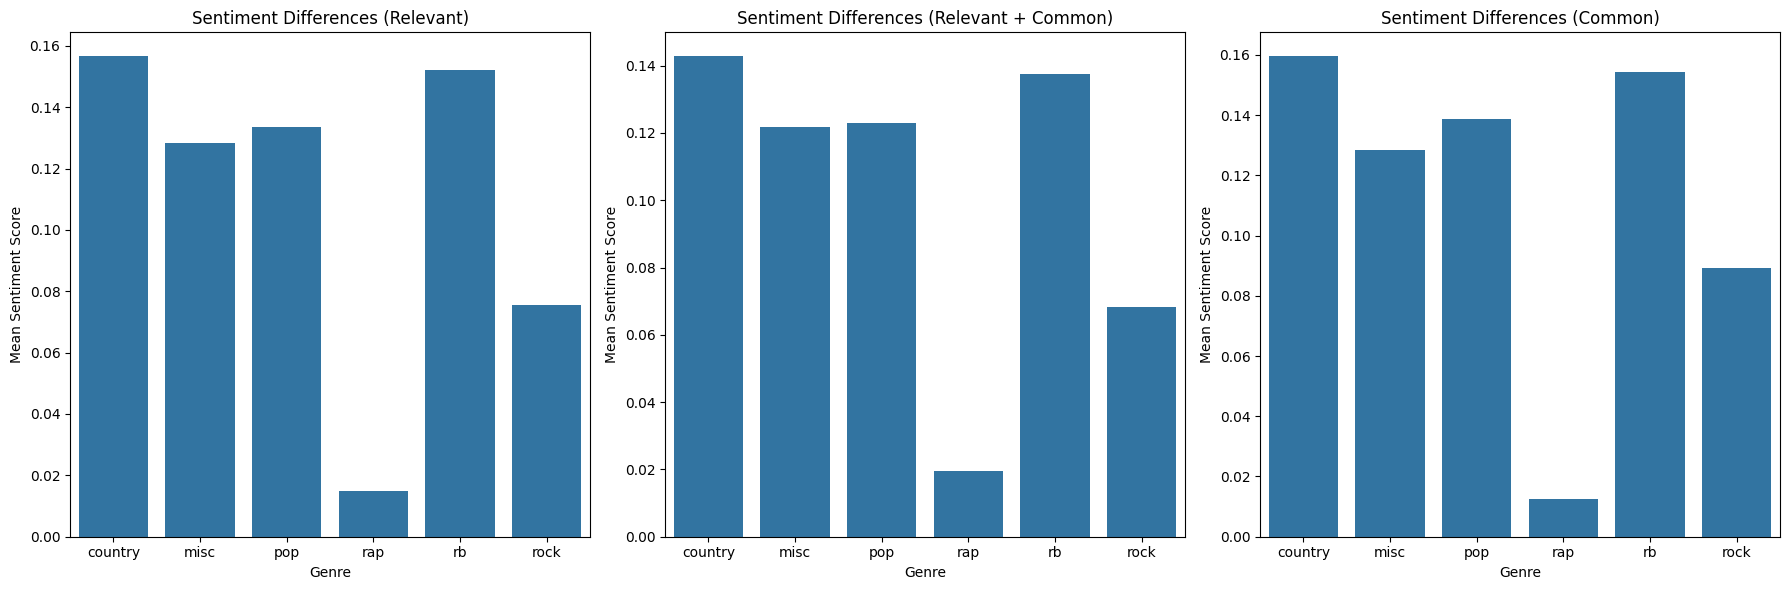

In [120]:
dataframes = [emojis_relevant_df2_by_gender, emojis_relevant_common_df2_by_gender, emojis_common_df2_by_gender]
titles = ['Relevant', 'Relevant + Common', 'Common']

sentiment_differences_across_genres(dataframes, titles, ncols=3)

#### Without Emojis and With Stopwords

relevant VS revelant + common VS common

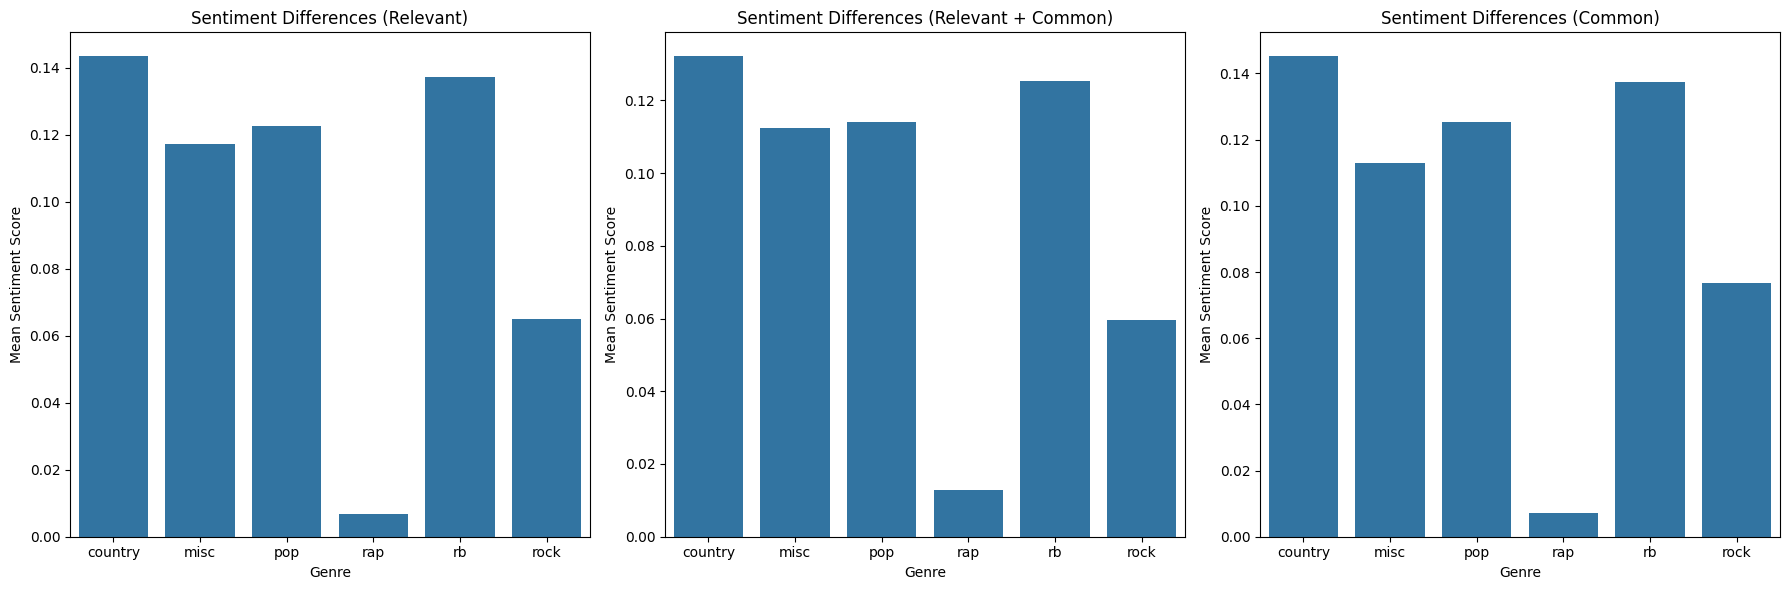

In [121]:
dataframes = [stopwords_relevant_df2_by_gender, stopwords_relevant_common_df2_by_gender, stopwords_common_df2_by_gender]
titles = ['Relevant', 'Relevant + Common', 'Common']

sentiment_differences_across_genres(dataframes, titles, ncols=3)

#### Relevant

With Emojis and Without Stopwords VS Without Emojis and With Stopwords

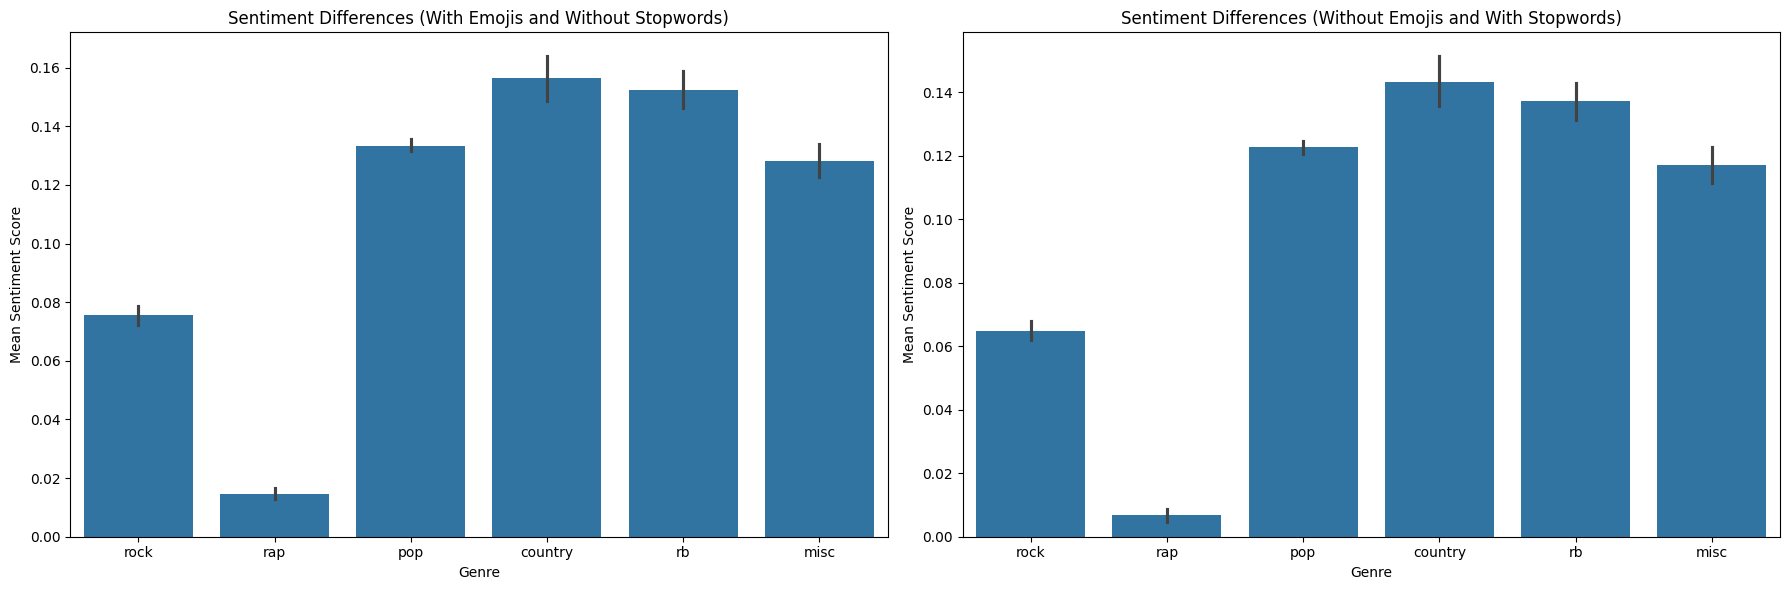

In [122]:
dataframes = [emojis_relevant_df2, stopwords_relevant_df2]
titles = ['With Emojis and Without Stopwords', 'Without Emojis and With Stopwords']

sentiment_differences_across_genres(dataframes, titles, ncols=2)

#### Revelant + Common

With Emojis and Without Stopwords VS Without Emojis and With Stopwords

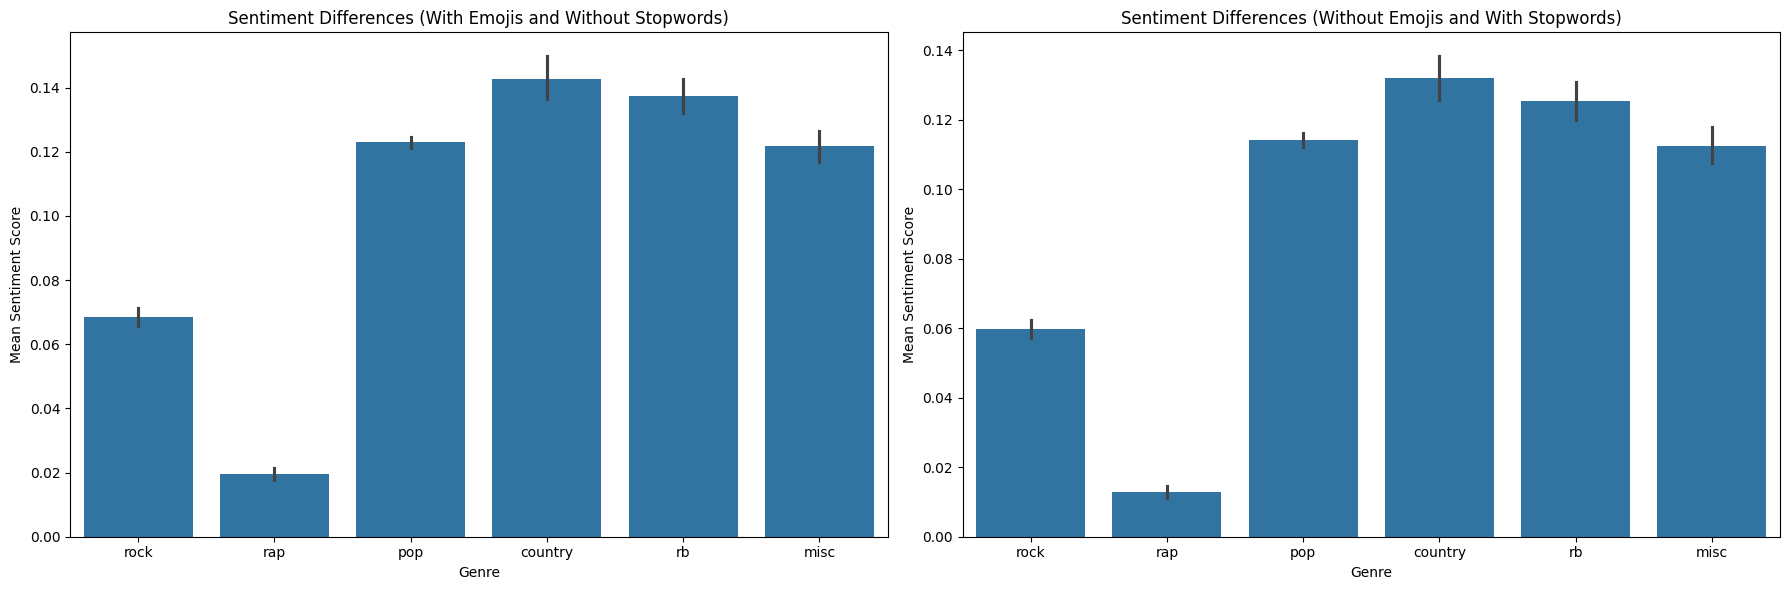

In [123]:
dataframes = [emojis_relevant_common_df2, stopwords_relevant_common_df2]
titles = ['With Emojis and Without Stopwords', 'Without Emojis and With Stopwords']

sentiment_differences_across_genres(dataframes, titles, ncols=2)

#### Common

With Emojis and Without Stopwords VS Without Emojis and With Stopwords

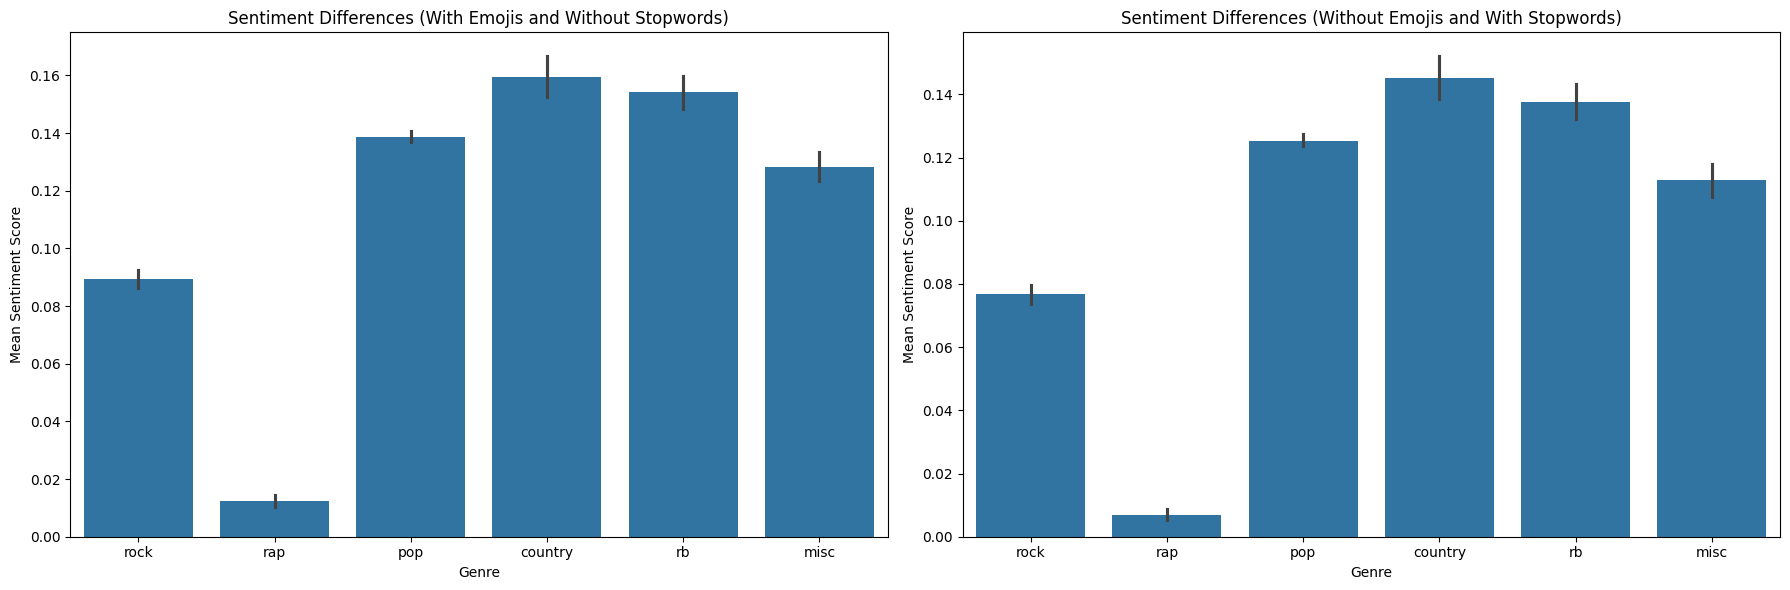

In [124]:
dataframes = [emojis_common_df2, stopwords_common_df2]
titles = ['With Emojis and Without Stopwords', 'Without Emojis and With Stopwords']

sentiment_differences_across_genres(dataframes, titles, ncols=2)

# **Explore**

### **Predominant sentiments in the lyrics of the songs of a specific musical genre:**

In [125]:
##### ines :)

### **Analyze Changes Over Years:**

- Group data by genre and year to see how sentiments change over time.
- Identify trends or shifts in emotional tones within genres across different years.

In [126]:
emojis_relevant_df[["year", "tag"]] = train[["year", "tag"]]
# emojis_relevant_common_df[["year", "tag"]] = train[["year", "tag"]]
# emojis_common_df[["year", "tag"]] = train[["year", "tag"]]

# stopwords_relevant_df[["year", "tag"]] = train[["year", "tag"]]
# stopwords_relevant_common_df[["year", "tag"]] = train[["year", "tag"]]
# stopwords_common_df[["year", "tag"]] = train[["year", "tag"]]

# emojis_relevant_df2[["year", "tag"]] = train[["year", "tag"]]
# emojis_relevant_common_df2[["year", "tag"]] = train[["year", "tag"]]
# emojis_common_df2[["year", "tag"]] = train[["year", "tag"]]

# stopwords_relevant_df2[["year", "tag"]] = train[["year", "tag"]]
# stopwords_relevant_common_df2[["year", "tag"]] = train[["year", "tag"]]
# stopwords_common_df2[["year", "tag"]] = train[["year", "tag"]]

In [132]:
emojis_relevant_df_copy = emojis_relevant_df.copy()

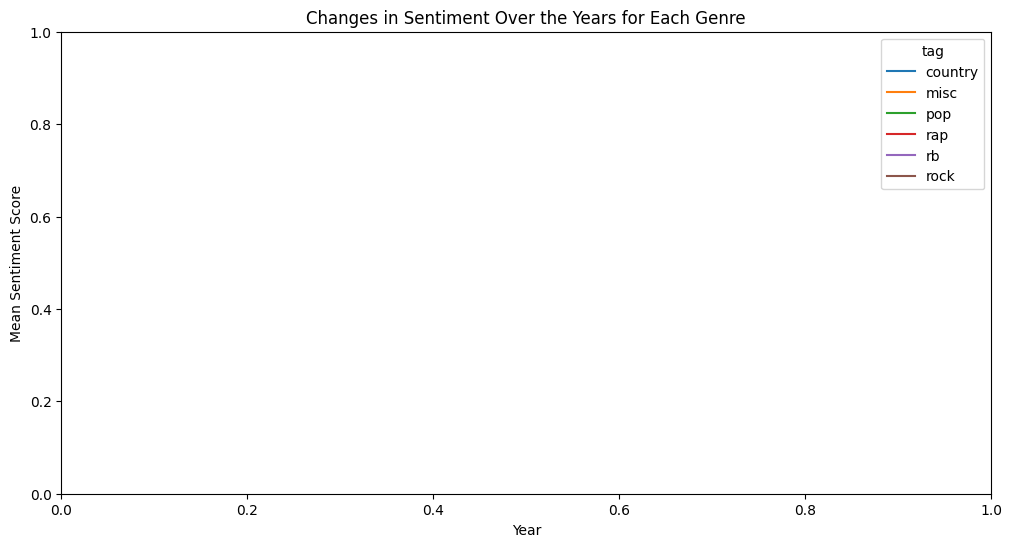

In [134]:
# Convert the 'sentiment' column to numeric
emojis_relevant_df_copy['sentiment_label'] = pd.to_numeric(emojis_relevant_df_copy['sentiment_label'], errors='coerce')

# Group by genre and year, then calculate the mean sentiment
genre_year_sentiment = emojis_relevant_df_copy.groupby(['tag', 'year'])['sentiment_label'].mean().reset_index()

# Visualize changes over the years
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='sentiment_label', hue='tag', data=genre_year_sentiment)
plt.title('Changes in Sentiment Over the Years for Each Genre')
plt.xlabel('Year')
plt.ylabel('Mean Sentiment Score')
plt.show()

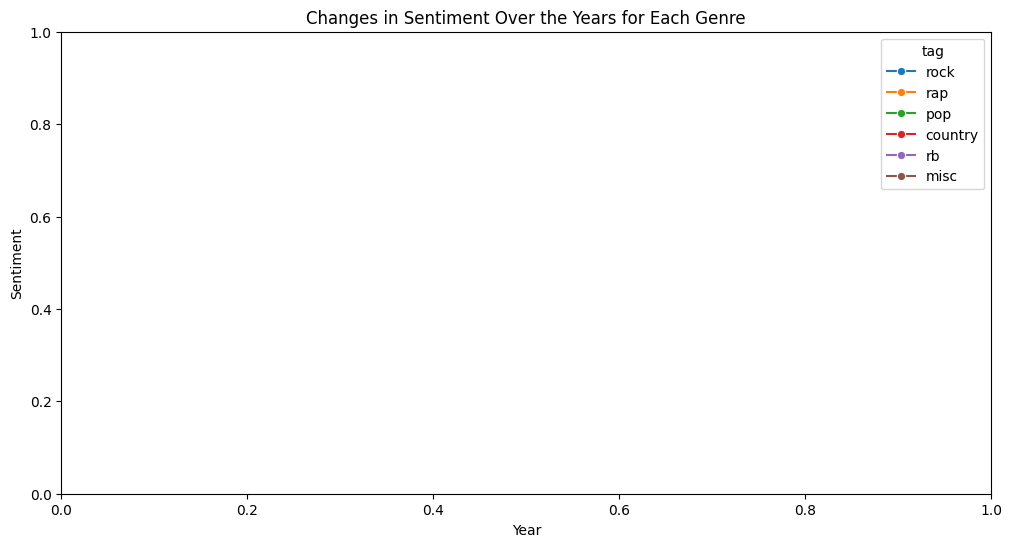

In [139]:
# Visualize changes over the years for each genre
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='sentiment_label', hue='tag', data=emojis_relevant_df_copy, marker='o')
plt.title('Changes in Sentiment Over the Years for Each Genre')
plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='sentiment', hue='genre', data=genre_year_sentiment)
plt.title('Changes in Sentiment Over the Years for Each Genre')
plt.xlabel('Year')
plt.ylabel('Mean Sentiment Score')
plt.show()

In [ ]:
# agrupar anos

In [ ]:
lyrics_preproc[]

### **Explore the Impact on Popularity:**

- Investigate whether sentiment correlates with song popularity (views).
- Analyze if certain sentiments are more appealing to audiences within and across genres.

### **Collaborations and Sentiment:**
   - How does the sentiment of a song vary when there are collaborations with other artists?
   - Do collaborations tend to result in songs with more positive or diverse sentiments?

### **Sentiment and Song Popularity:**
   - Is there a correlation between the sentiment of a song and its popularity (number of views)?
   - Do songs with certain sentiments tend to attract more views?

### **Lyrics Length and Sentiment:**
   - Is there a correlation between the length of song lyrics and the expressed sentiment?
   - Do shorter or longer lyrics tend to convey specific sentiments?

### **Cross-Genre Sentiment Analysis:**
   - Are there common sentiments shared between different genres, and how do they differ?
   - How do sentiments vary when songs from different genres collaborate or blend influences?

In [142]:
##### so depois da parte da ines :)

### **Impact of Lyrics on Views:**
- Is there evidence that certain sentiments in lyrics contribute to more views on the online music service?
- Do specific sentiments correlate with songs that go viral or become trending?

### **Sentiment and Musical Trends:**
- Are there patterns in sentiment that align with broader musical trends or movements?
- How does sentiment correlate with the evolution of music styles over time?

### By gender

In [ ]:
# ### country
# country_positive_df = labels_df[(labels_df['tag'] == "country") & (labels_df['compound'] > 0.2)]
# country_df = labels_df[labels_df['tag'] == "country"]
# country_overall = len(country_positive_df["compound"]) / len(country_df["compound"])*100
# display(country_overall)

73.16791690709752

In [ ]:
# ### misc
# misc_positive_df = labels_df[(labels_df['tag'] == "misc") & (labels_df['compound'] > 0.2)]
# misc_df = labels_df[labels_df['tag'] == "misc"]
# misc_overall = len(misc_positive_df["compound"]) / len(misc_df["compound"])*100
# display(misc_overall)

65.31914893617021

### Export Dataset

In [ ]:
# lyrics_train = pd.read_csv(r'C:\Users\bruna\Desktop\data_updated\lyrics_train.csv', index_col=-1)